In [7]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.stats import norm


In [8]:
def gaussian_pdf(x, mean, var):
    epsilon = 1e-6
    var = np.maximum(var, epsilon)
    
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - mean) ** 2) / (2 * var))

def cal_expectation(data, means, variances, weights, k):
    responsibilities = np.zeros((len(data), k))
    
    for i in range(k):
        weight = weights[i]
        pdf_value = gaussian_pdf(data, means[i], variances[i])
        responsibilities[:, i] = weight * pdf_value
    
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def cal_maximization(data, responsibilities, k):    
    Nk = responsibilities.sum(axis=0)

    weighted_sum = responsibilities * data[:, None]  
    sum_weighted = weighted_sum.sum(axis=0)
    means = sum_weighted / Nk  

    diffs = data[:, None] - means  
    squared_diffs = diffs ** 2  
    weighted_squared_diffs = responsibilities * squared_diffs  
    sum_weighted_squared = weighted_squared_diffs.sum(axis=0)
    variances = sum_weighted_squared / Nk  

    # **Regularize variance to prevent collapse**
    variances = np.maximum(variances, 5)  # Set a reasonable lower bound

    weights = Nk / len(data)

    return means, variances, weights


def gmm_em(means, variances, weights, data, k=3, tol=1e-2, max_iter=20):
    
    for i in range(max_iter):
        # print(i)
        old_means = np.array(means)

        responsibilities = cal_expectation(data, means, variances, weights, k)
        
        means, variances, weights = cal_maximization(data, responsibilities, k)

        if np.linalg.norm(means - old_means) < tol:
            break
    
    return means, variances, weights, responsibilities

In [9]:
img_nifti = nib.load("sald_031764_img.nii")
img_data = img_nifti.get_fdata().flatten()  # min = 0, max = 198

csf_gt = nib.load("sald_031764_probmask_csf.nii").get_fdata().flatten()
gray_gt = nib.load("sald_031764_probmask_graymatter.nii").get_fdata().flatten()
white_gt = nib.load("sald_031764_probmask_whitematter.nii").get_fdata().flatten()

In [10]:
actual_labels = np.argmax(np.stack([csf_gt, gray_gt, white_gt]), axis=0)
num_components = 3


# Remove zero values for better initialization
non_zero_data = img_data[img_data > 0]

# Choose means from percentiles (avoiding zeros)
percentiles_for_means = np.percentile(non_zero_data, [25, 50, 75])
means = np.array(percentiles_for_means)

# Initialize variances using the variance of non-zero values
variances = np.full(num_components, max(np.var(non_zero_data), 1e-6))

# Initialize equal weights
weights = np.full(num_components, 1 / num_components)

# Print initialized values
print(f"Initialized Means: {means}")
print(f"Initialized Variances: {variances}")
print(f"Initialized Weights: {weights}")


means, variances, weights, responsibilities = gmm_em(means, variances, weights, img_data, num_components)

predicted_segmentation = np.argmax(responsibilities, axis=1)

# Compute pointwise accuracy
accuracy = np.mean(predicted_segmentation == actual_labels)

print(f"Pointwise Segmentation Accuracy: {accuracy:.4f}")

Initialized Means: [ 62.  82. 103.]
Initialized Variances: [916.73529043 916.73529043 916.73529043]
Initialized Weights: [0.33333333 0.33333333 0.33333333]
Pointwise Segmentation Accuracy: 0.8561


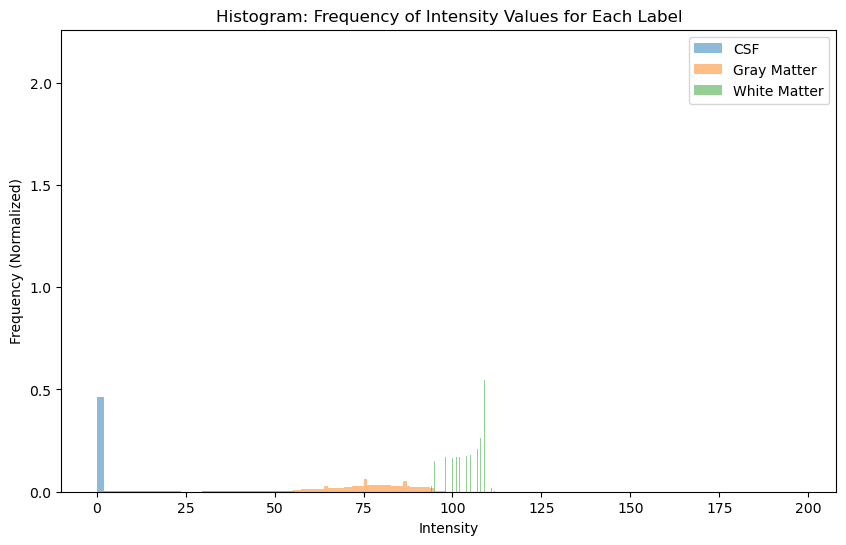

In [11]:
plt.figure(figsize=(10, 6))

# Plot histogram for each label
plt.hist(img_data[actual_labels == 0], bins=100, alpha=0.5, label="CSF", density=True)
plt.hist(img_data[actual_labels == 1], bins=100, alpha=0.5, label="Gray Matter", density=True)
plt.hist(img_data[actual_labels == 2], bins=100, alpha=0.5, label="White Matter", density=True)

plt.xlabel("Intensity")
plt.ylabel("Frequency (Normalized)")
plt.title("Histogram: Frequency of Intensity Values for Each Label")
plt.legend()
plt.show()

[5.96980699e-02 5.56925710e+01 9.45902344e+01]
[  5.         705.00308596 197.33715873]
[0.71610972 0.11046049 0.17342978]


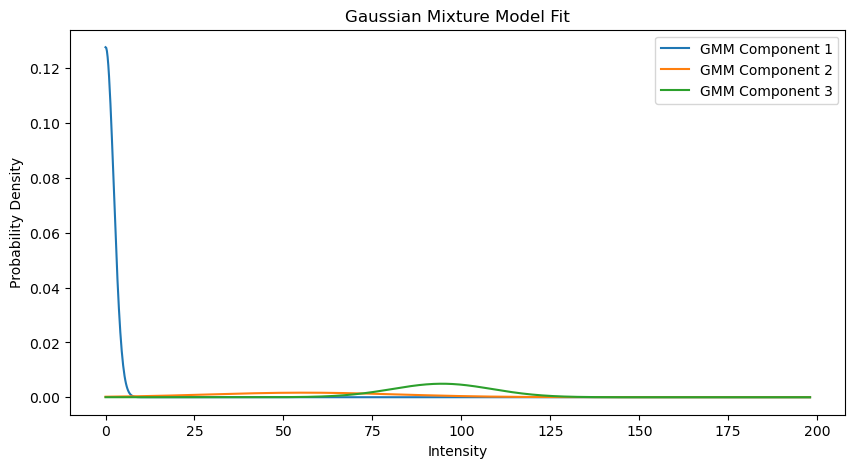

In [12]:
x = np.linspace(img_data.min(), img_data.max(), 1000)

# Compute GMM distributions
print(means)
print(variances)
print(weights)
gmm_distributions = [
    weights[i] * norm.pdf(x, means[i], np.sqrt(variances[i])) for i in range(3)
]

plt.figure(figsize=(10, 5))

# Plot histograms for reference
# plt.hist(img_data, bins=100, alpha=0.3, color="gray", density=True, label="Intensity Histogram")

# Plot GMM components
for i, dist in enumerate(gmm_distributions):
    # if i==1 or i==2:
    plt.plot(x, dist, label=f"GMM Component {i+1}")

# plt.plot(x, dist, label=f"GMM Component {i+1}")

plt.xlabel("Intensity")
plt.ylabel("Probability Density")
plt.title("Gaussian Mixture Model Fit")
plt.legend()
plt.show()

In [13]:
segmented_image = predicted_segmentation.astype(np.int16).reshape(img_nifti.shape)

# Create a new NIfTI image
segmented_nifti = nib.Nifti1Image(segmented_image, affine=img_nifti.affine)

# Save the segmented image
nib.save(segmented_nifti, "segmented_image.nii")

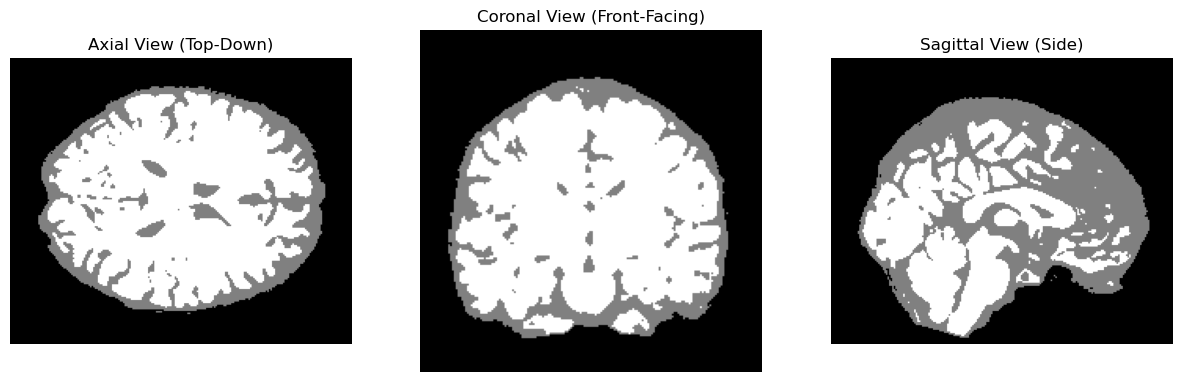

In [ ]:
mid_axial = segmented_image.shape[2] // 2  # Axial (Z-axis)
mid_coronal = segmented_image.shape[1] // 2  # Coronal (Y-axis)
mid_sagittal = segmented_image.shape[0] // 2  # Sagittal (X-axis)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial View (Top-Down)
axes[0].imshow(segmented_image[:, :, mid_axial], cmap='gray')
axes[0].set_title("Axial View (Top-Down)")
axes[0].axis("off")

# Coronal View (Front-Facing)
axes[1].imshow(np.rot90(segmented_image[:, mid_coronal, :]), cmap='gray')
axes[1].set_title("Coronal View (Front-Facing)")
axes[1].axis("off")

# Sagittal View (Side View)
axes[2].imshow(np.rot90(segmented_image[mid_sagittal, :, :]), cmap='gray')
axes[2].set_title("Sagittal View (Side)")
axes[2].axis("off")

plt.show()


The highest misclassification is likely occurring in the overlapping region between the orange (gray matter) and green (white matter) curves, around intensity values between 75 and 125. This happens because:

Overlap of Gaussian Distributions: The probability densities of gray matter and white matter significantly overlap in this region, making it difficult for the model to distinguish between the two.
Low Separation: The Gaussian components are not well-separated, meaning that a single intensity value could belong to either class with almost equal probability.
CSF (Blue) is Well-Separated: The cerebrospinal fluid (CSF) distribution (blue) is sharply peaked near intensity 0 and does not overlap significantly with the other two, meaning it has minimal misclassification.
Thus, the highest misclassification occurs between gray matter and white matter due to their overlapping probability densities.